<a href="https://colab.research.google.com/github/sekihiro/Colabo/blob/master/Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorchでSeq2Seq
- 最大３桁の非負整数同士の引き算をSeq2Seqに学習させる
- https://qiita.com/m__k/items/b18756628575b177b545

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!nvidia-smi

Tue Feb 11 07:45:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [5]:
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


In [0]:
import os
import sys
import pprint
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import Image, display_png
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# 再現性確保
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    return seed

# 再現性確保
ret = seed_everything(1234)
print('seed : {}'.format(ret))

# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device : {}'.format(device))

seed : 1234
device : cuda


### 定数定義

In [0]:
BASE_PATH = "/content/drive/My Drive/git/"

DATA_CNT = 50000
#DATA_CNT = 10

BATCH_NUM = 100
EPOCH_NUM = 100
#BATCH_NUM = 2
#EPOCH_NUM = 1

embedding_dim = 200 # 文字の埋め込み次元数
hidden_dim = 128 # LSTMの隠れ層のサイズ

### データ準備
- 空白 ： (10)
- マイナス符号 ： (11)
- 系列生成開始文字 ： (12)

In [9]:
# 数字の文字をID化
char2id = {str(i) : i for i in range(10)}
print(char2id)

# 空白(10)：系列の長さを揃えるようのパディング文字
# -(11)：マイナスの文字
# _(12)：系列生成開始を知らせる文字
char2id.update({" ":10, "-":11, "_":12})
print(char2id)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, ' ': 10, '-': 11, '_': 12}


In [10]:
# １〜３桁の数字をランダムに生成
def generate_number():
    number = [random.choice(list("0123456789")) for _ in range(random.randint(1, 3))]
    str_num = "".join(number)
    #print('[' + str_num + ']')
    return int(str_num)

# 系列の長さを揃えるために空白パディング
# 引き算の式は最大７桁 (例)123-456
# 引き算の答えは最大５桁 (マイナス記号、系列生成開始文字を含む)))
def add_padding(number, is_input=True):
    # 空白を入れて左寄
    number = "{: <7}".format(number) if is_input else "{: <5}".format(number)
    return number

# 確認
num = generate_number()
print("[" + str(num) + "]")
print("[" + str(add_padding(num)) + "]")
print("[" + str(add_padding(num, False)) + "]")
# [31]
# [31      ]
# [31  ]

[10]
[10     ]
[10   ]


In [11]:
input_data = []
output_data = []

# データ準備する
for i in range(int(DATA_CNT)):

    # １〜３桁の数字を２つランダム生成
    x = generate_number()
    y = generate_number()

    # 引き算実行
    z = x - y

    # 系列の長さを揃えるために空白パディング
    input_char = add_padding(str(x) + "-" + str(y))
    output_char = add_padding("_" + str(z), is_input=False)

    # データをIDにに変換
    # 10 → 空白(系列の長さを揃えるようのパディング文字)
    # 11 → - (マイナスの文字)
    # 12 → _ (系列生成開始を知らせる文字)
    input_data.append([char2id[c] for c in input_char])
    output_data.append([char2id[c] for c in output_char])

    if i == 0:
        print('【i = 0】')
        print('x : {}'.format(x))
        print('y : {}'.format(y))
        print('z : {}'.format(z))
        print('input_data : {}'.format(input_data))
        print('output_data : {}'.format(output_data))
        # x : 44
        # y : 6
        # z : 38
        # input_data : [[4, 4, 11, 6, 10, 10, 10]]
        # output_data : [[12, 3, 8, 10, 10]]
    elif i == 1:
        print('\n【i = 1】')
        print('x : {}'.format(x))
        print('y : {}'.format(y))
        print('z : {}'.format(z))
        print('input_data : {}'.format(input_data))
        print('output_data : {}'.format(output_data))
        # x : 0
        # y : 884
        # z : -884
        # input_data : [[4, 4, 11, 6, 10, 10, 10], [0, 11, 8, 8, 4, 10, 10]]
        # output_data : [[12, 3, 8, 10, 10], [12, 11, 8, 8, 4]]

# ７：３にデータをわける
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size= 0.7)
print('\ntrain_x[equation] : {}'.format(len(train_x)))
print('train_y[answer] : {}'.format(len(train_y)))
print('test_x[equation] : {}'.format(len(test_x)))
print('test_y[answer] : {}'.format(len(test_y)))

【i = 0】
x : 9
y : 1
z : 8
input_data : [[9, 11, 1, 10, 10, 10, 10]]
output_data : [[12, 8, 10, 10, 10]]

【i = 1】
x : 5
y : 0
z : 5
input_data : [[9, 11, 1, 10, 10, 10, 10], [5, 11, 0, 10, 10, 10, 10]]
output_data : [[12, 8, 10, 10, 10], [12, 5, 10, 10, 10]]

train_x[equation] : 35000
train_y[answer] : 35000
test_x[equation] : 15000
test_y[answer] : 15000


In [0]:
# データをバッチ化するための関数
def train2batch(input_data, output_data, batch_size):
    input_batch = []
    output_batch = []
    input_shuffle, output_shuffle = shuffle(input_data, output_data)
    for i in range(0, len(input_data), batch_size):
      input_batch.append(input_shuffle[i:i+batch_size])
      output_batch.append(output_shuffle[i:i+batch_size])
    return input_batch, output_batch

### モデル定義

#### Encoder
- 最終隠れ層を返す

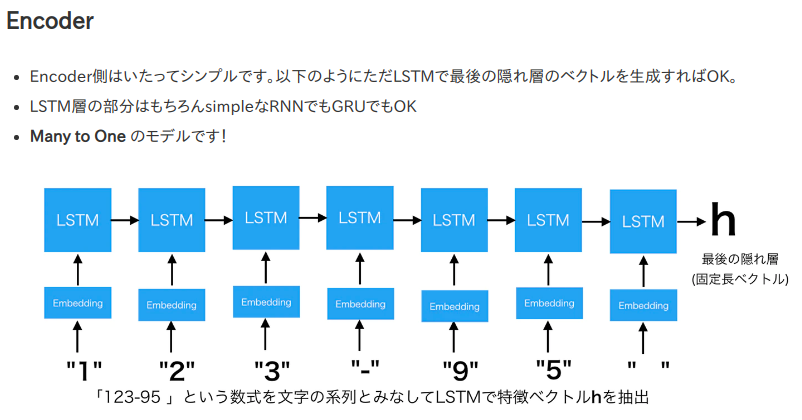

In [13]:
display_png(Image("/content/drive/My Drive/git/images/seq2seq01.png"))

In [0]:
vocab_size = len(char2id) # 扱う文字の数。今回は13文字

# Encoderクラス
class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        # 親クラスのコンストラクタ。決まり文句
        super(Encoder, self).__init__()
        # 隠れ層の次元数
        self.hidden_dim = hidden_dim
        # インプットの単語をベクトル化するために使う
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        # LSTMの隠れ層
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Linearの層の値が一番大きいものを予測値とみなせばよいので、softmaxをかます必要はありません。

    def forward(self, sequence):
        # 文章内の各単語をベクトル化して出力。
        embedding = self.word_embeddings(sequence)
        # Many to One、第２戻り値(最終隠れ層)を使う
        _, state = self.lstm(embedding)
        # state = (h, c)
        return state

#### Decoder
- Decoderの予測値は最大値をそのまま使えばいいので、softmaxは不要

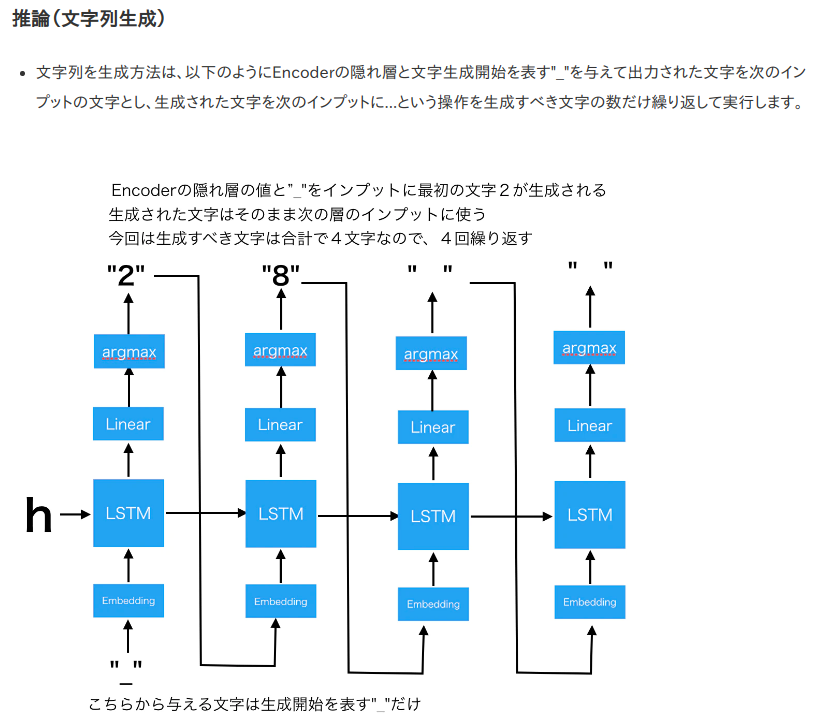

In [15]:
display_png(Image("/content/drive/My Drive/git/images/seq2seq02.png"))

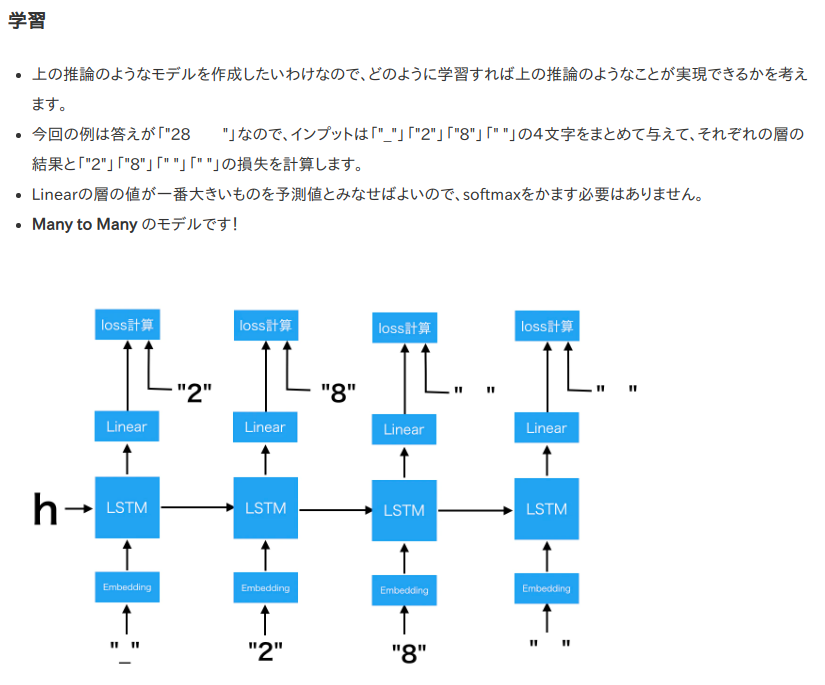

In [16]:
display_png(Image("/content/drive/My Drive/git/images/seq2seq03.png"))

In [0]:
vocab_size = len(char2id) # 扱う文字の数。今回は13文字

# Decoderクラス
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        # 親クラスのコンストラクタ。決まり文句
        super(Decoder, self).__init__()
        # 隠れ層の次元数
        self.hidden_dim = hidden_dim
        # インプットの単語をベクトル化するために使う
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        # LSTMの隠れ層
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # LSTMの128次元の隠れ層を13次元に変換する全結合層
        self.hidden2linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, sequence, encoder_state):
        # 文章内の各単語をベクトル化して出力。
        embedding = self.word_embeddings(sequence)
        # Many to Manyなので、第１戻り値を使う。
        # 第２戻り値(隠れ層)は推論時に次の文字を生成するときに使います。
        output, state = self.lstm(embedding, encoder_state)
        output = self.hidden2linear(output)
        return output, state

### モデル宣言、損失関数、最適化

In [0]:
encoder = Encoder(vocab_size, embedding_dim, hidden_dim).to(device)
decoder = Decoder(vocab_size, embedding_dim, hidden_dim).to(device)

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

### 学習


In [19]:
all_losses = []
print("training ...\n\n")

for epoch in range(1, EPOCH_NUM+1):

    epoch_loss = 0 # epoch毎のloss

    # データをミニバッチに分ける
    # train_x : equation
    # train_y : answer
    input_batch, output_batch = train2batch(train_x, train_y, batch_size=BATCH_NUM)

    for i in range(len(input_batch)):

        # 勾配の初期化
        # モデルが持ってる勾配の情報をリセット
        # 毎回バックプロパゲーションの初期値をリセット(勾配リセット)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # データをテンソルに変換
        input_tensor = torch.tensor(input_batch[i], device=device)
        output_tensor = torch.tensor(output_batch[i], device=device)
        #print('input_tensor : {}'.format(input_tensor))
        #print('output_tensor : {}'.format(output_tensor))

        # Encoderの順伝搬(forwardが呼ばれる)
        # 最終隠れ層(seq2seq01.pngのh)を得る
        encoder_state = encoder(input_tensor)

        # Decoderで使うデータはoutput_tensorを１つずらしたものを使う
        # Decoderのインプットとするデータ
        # decoder(source, encoder_state) で使う 'source' を出す
        # 学習時は、output_tensor(answer)の最後のカラムは使わない
        # seq2seq03.png の下端部分を参照
        # １カラム減らすので、最大で４文字となる
        source = output_tensor[:, :-1]
        #print('source : {}'.format(source))

        # Decoderのloss計算用データ
        # 生成開始を表す"_"を削っている
        # seq2seq03.png の上端(loss計算)の部分を参照
        target = output_tensor[:, 1:]
        #print('target : {}'.format(target))

        loss = 0
        # 学習時はDecoderはこのように１回呼び出すだけでグルっと系列をループしているからこれでOK
        # sourceが４文字なので、以下でLSTMが4回再帰的な処理してる
        # 引数は
        # 　answerの最後のカラムはを除いたもの
        # 　encoderで出力された最終隠れ層
        # 戻り値(第１引数)は
        # 　予測結果
        decoder_output, _ = decoder(source, encoder_state)
        #print('decoder_output : {}'.format(decoder_output))
        #print('decoder_output.size() : {}'.format(decoder_output.size()))
        # decoder_output.size() = (BATCH_NUM, 4, 13)
        # 「13」は生成すべき対象の文字が13文字あるから。decoder_outputの3要素目は
        # [-14.6240,  -3.7612, -11.0775,  ...,  -5.7391, -15.2419,  -8.6547]
        # こんな感じの値が入っており、これの最大値に対応するインデックスを予測文字とみなす

        for j in range(decoder_output.size()[1]):
            # バッチ毎にまとめてloss計算
            # 生成する文字は4文字なので、4回ループ
            # seq2seq03.png の上端(loss計算)の部分を参照
            # target[:, j] → 100*4 の行列のうち、j列目だけを抽出し1次元の行列にしたもの
            # decoder_output[:, j, :] → 100*4*13の行列のうち、2次元目がjのものだけを抽出し、2次元配列にしたもの
            loss += criterion(decoder_output[:, j, :], target[:, j])

        epoch_loss += loss.item()

        # 誤差逆伝播
        # 誤差のバックプロパゲーション(逆伝播)で勾配を求める
        loss.backward()

        # パラメータ更新
        # Encoder、Decoder両方学習
        # バックプロパゲーションで計算した勾配を元に重みを更新
        encoder_optimizer.step()
        decoder_optimizer.step()
        #print('-----------------------------')

    # 損失を表示
    print("Epoch {} : loss -> {:.5f}".format(epoch, epoch_loss))
    all_losses.append(epoch_loss)
    #if epoch_loss < 1: break

print("\n\n Done...")

training ...


Epoch 1 : loss -> 1863.49178
Epoch 2 : loss -> 1353.56565
Epoch 3 : loss -> 1157.64527
Epoch 4 : loss -> 1033.73370
Epoch 5 : loss -> 943.83606
Epoch 6 : loss -> 870.40681
Epoch 7 : loss -> 799.87526
Epoch 8 : loss -> 741.68089
Epoch 9 : loss -> 681.54052
Epoch 10 : loss -> 623.77343
Epoch 11 : loss -> 568.03561
Epoch 12 : loss -> 524.18765
Epoch 13 : loss -> 480.69703
Epoch 14 : loss -> 442.78299
Epoch 15 : loss -> 413.31050
Epoch 16 : loss -> 382.70289
Epoch 17 : loss -> 354.49834
Epoch 18 : loss -> 333.90846
Epoch 19 : loss -> 311.35621
Epoch 20 : loss -> 291.81356
Epoch 21 : loss -> 276.03090
Epoch 22 : loss -> 257.76226
Epoch 23 : loss -> 251.20232
Epoch 24 : loss -> 239.00842
Epoch 25 : loss -> 226.59940
Epoch 26 : loss -> 214.57114
Epoch 27 : loss -> 210.56747
Epoch 28 : loss -> 195.00125
Epoch 29 : loss -> 187.94254
Epoch 30 : loss -> 180.86882
Epoch 31 : loss -> 171.93946
Epoch 32 : loss -> 164.74834
Epoch 33 : loss -> 161.80433
Epoch 34 : loss -> 154.24564
Epoc

### 学習曲線

In [0]:
# decoder_output[:, j, :], target[:, j] の確認

#print(decoder_output.size())
#print(decoder_output)
#print(decoder_output[:, 0, :])
#print(decoder_output[:, 1, :])

#print(target.size())
#print(target)
#print(target[:, 0])
#print(target[:, 1])

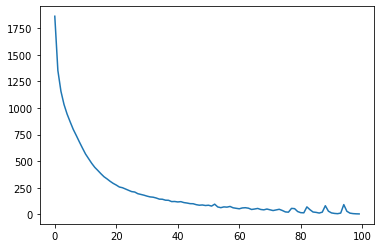

In [21]:
plt.plot(all_losses)

#### 評価

In [22]:
# Decoderのアウトプットのテンソルから要素が最大のインデックスを返す。つまり生成文字を意味する
def get_max_index(decoder_output):
    results = []
    for h in decoder_output:
        results.append(torch.argmax(h))
    return torch.tensor(results, device=device).view(BATCH_NUM, 1)

# 評価用データの準備
test_input_batch, test_output_batch = train2batch(test_x, test_y, batch_size=BATCH_NUM)
input_tensor = torch.tensor(test_input_batch, device=device)

predicts = []
for i in range(len(test_input_batch)):

    # torch.no_gradで必要のない計算を停止 パラメータの保存を止める(test時にメモリが溢れてしまうのを防止)
    with torch.no_grad():

        encoder_state = encoder(input_tensor[i])

        # Decoderにはまず文字列生成開始を表す"_"をインプットにするので、"_"のtensorをバッチサイズ分作成
        start_char_batch = [[char2id["_"]] for _ in range(BATCH_NUM)]
        decoder_input_tensor = torch.tensor(start_char_batch, device=device)

        # 変数名変換
        decoder_hidden = encoder_state

        # バッチ毎の結果を結合するための入れ物を定義
        batch_tmp = torch.zeros(100, 1, dtype=torch.long, device=device)
        # print(batch_tmp.size())
        # (100,1)

        for _ in range(4): # 5->4 に変更 (生成される文字はマイナス符号も含めて４文字なので)
            decoder_output, decoder_hidden = decoder(decoder_input_tensor, decoder_hidden)
            # 予測文字を取得しつつ、そのまま次のdecoderのインプットとなる
            # torch.squeezeは要素数が1のみの軸を削除してくれます
            decoder_input_tensor = get_max_index(decoder_output.squeeze())
            # バッチ毎の結果を予測順に結合
            # torch.cat : torch.Tensorをリスト入れてして渡すことで、それらを連結したTensorを返してくれます
            # 連結する軸はdimによって指定します。
            batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)

        # 最初のbatch_tmpの0要素が先頭に残ってしまっているのでスライスして削除
        predicts.append(batch_tmp[:,1:])

# バッチ毎の予測結果がまとまって格納されてます。
print(len(predicts))
# 150
print(predicts[0].size())
# (100, 5)

150
torch.Size([100, 4])


### 上でまとめたpredictsをDataFrameにまとめるための処理を以下で実行
- accuracyも計算

In [23]:
id2char = {str(i) : str(i) for i in range(10)}
id2char.update({"10":"", "11":"-", "12":""})

row = []
for i in range(len(test_input_batch)):

    batch_input = test_input_batch[i]
    batch_output = test_output_batch[i]
    batch_predict = predicts[i]

    for inp, output, predict in zip(batch_input, batch_output, batch_predict):
        x = [id2char[str(idx)] for idx in inp]
        y = [id2char[str(idx)] for idx in output]
        p = [id2char[str(idx.item())] for idx in predict]

    x_str = "".join(x)
    y_str = "".join(y)
    p_str = "".join(p)

    judge = "O" if y_str == p_str else "X"
    row.append([x_str, y_str, p_str, judge])

predict_df = pd.DataFrame(row, columns=["input", "answer", "predict", "judge"])
# input: 予測対象
# answer: 正解
# predict: 予測結果
# judge: 予測が正しければ"O"、間違っていたら"X"

# 正解率を表示
print('acc:')
print(len(predict_df.query('judge == "O"')) / len(predict_df))
print('\n')
# 0.8492

# 間違えたデータを一部見てみる
print(predict_df.query('judge == "X"').head(10))
print('\n')
print(predict_df.query('judge == "O"').head(10))

acc:
0.8866666666666667


      input answer predict judge
0   645-203    442     432     X
8   503-849   -346    -376     X
10   842-97    745     755     X
21  383-549   -166    -186     X
32  576-945   -369    -381     X
43  202-565   -363    -443     X
44   78-133    -55     -45     X
73   84-233   -149    -159     X
82   479-20    459     469     X
93  984-912     72      92     X


     input answer predict judge
1   82-745   -663    -663     O
2     35-1     34      34     O
3     72-4     68      68     O
4      6-6      0       0     O
5      5-2      3       3     O
6    72-26     46      46     O
7    290-6    284     284     O
9    65-29     36      36     O
11    96-6     90      90     O
12   262-8    254     254     O


In [0]:
#x = torch.rand(3,5)
#print(x)
## 3 x 5の配列について、各行ごとに最大の値をもつ、列番号を返す
#print(x.argmax(1))